### TODOS: Wrap in Function, HPO, Class imbalance

In [1]:
import numpy as np
import pandas as pd 
import h5py

In [101]:
#Modelling libraries
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split,  GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

#from sklearn.feature_selection import VarianceThreshold <- use to remove low variance features

from bayes_opt import BayesianOptimization #!pip install bayesian-optimization

In [29]:
file_path = r"C:\Users\likai\Desktop\My Life\Master\3. Semester\Innolabs\Test"

In [30]:
data = pd.read_csv(file_path + '\\train.csv')

In [31]:
data.head(2)

,ConnID,Repseudonym,siteid,age,visdat,sex,prmdiag,edyears,MEM_score,Apoe,...,242_243,242_244,242_245,242_246,243_244,243_245,243_246,244_245,244_246,245_246
0,241,40ea07c4b,17,70,20.04.2017,0,2,13,-0.704825,1.0,...,0.748460,0.672616,0.293294,0.160400,1.062753,0.071058,0.117238,0.129523,0.083228,0.902359
1,447,9017e3b68,13,69,22.04.2015,0,1,18,-0.070936,0.0,...,0.389067,0.475096,0.135471,-0.109216,0.456896,0.109648,0.123226,0.146611,0.130343,0.344798


In [32]:
#features.describe()
round(data.describe(), 2)

,ConnID,siteid,age,sex,prmdiag,edyears,MEM_score,Apoe,IDs,1_2,...,242_243,242_244,242_245,242_246,243_244,243_245,243_246,244_245,244_246,245_246
count,649.00,649.00,649.00,649.0,649.00,649.00,649.00,634.00,649.00,649.00,...,649.00,649.00,649.00,649.00,649.00,649.00,649.00,649.00,649.00,649.00
mean,404.80,10.65,70.65,0.5,1.18,14.63,0.28,0.31,404.80,0.71,...,0.51,0.41,0.05,0.13,0.56,0.09,0.17,0.07,0.09,0.51
std,232.58,5.39,6.03,0.5,1.13,2.92,0.71,0.46,232.58,0.27,...,0.22,0.20,0.18,0.20,0.24,0.20,0.21,0.17,0.19,0.23
min,1.00,2.00,60.00,0.0,0.00,8.00,-2.43,0.00,1.00,-0.00,...,0.00,-0.25,-0.54,-0.46,-0.09,-0.52,-0.63,-0.58,-0.75,-0.55
25%,199.00,5.00,66.00,0.0,0.00,12.00,-0.13,0.00,199.00,0.54,...,0.35,0.27,-0.08,-0.01,0.39,-0.04,0.04,-0.03,-0.02,0.35
50%,405.00,11.00,71.00,1.0,1.00,14.00,0.38,0.00,405.00,0.70,...,0.51,0.41,0.06,0.12,0.55,0.09,0.17,0.07,0.09,0.50
75%,606.00,16.00,75.00,1.0,2.00,17.00,0.79,1.00,606.00,0.87,...,0.66,0.53,0.17,0.26,0.71,0.20,0.30,0.18,0.21,0.67
max,813.00,18.00,88.00,1.0,4.00,20.00,1.74,1.00,813.00,1.71,...,1.34,1.36,0.64,0.78,1.32,0.77,0.88,0.59,0.97,1.19


In [33]:
#define target
data['prmdiag'].value_counts()

1    288
0    184
2    116
4     61
Name: prmdiag, dtype: int64

In [34]:
has_alzheimer = data.prmdiag.isin([2,3])
no_alzheimer = data.prmdiag.isin([0])

data.loc[has_alzheimer, 'target'] = 1
data.loc[no_alzheimer, 'target'] = 0

In [35]:
data.dropna(subset=['target'], axis = 0, inplace = True)

In [37]:
data.drop(['ConnID','Repseudonym','visdat','siteid','IDs', 'prmdiag'], axis = 1, inplace = True)

In [41]:
features = data.drop('target', axis = 1)
labels = data['target']

In [42]:
n_features = features.shape[1]

### Slight Class imbalance

In [43]:
labels.value_counts()

0.0    184
1.0    116
Name: target, dtype: int64

#### Train Test Split

In [44]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2, random_state = 42, stratify = labels)

#### impute missing values

In [45]:
features[features.isna().any(axis=1)]

,age,sex,edyears,MEM_score,Apoe,1_2,1_3,1_4,1_5,1_6,...,242_243,242_244,242_245,242_246,243_244,243_245,243_246,244_245,244_246,245_246
26,79,1,13,0.719214,NaN,0.797040,0.370490,0.059678,0.218447,-0.122462,...,0.363497,0.231037,0.252773,0.431979,0.552066,0.013893,0.161084,-0.142823,-0.075208,0.666441
230,69,1,13,0.708661,NaN,0.565332,0.332528,-0.015577,0.527998,0.265987,...,0.575368,0.379398,0.153072,0.188878,0.463371,0.099339,0.027374,0.127089,0.073215,0.146653
282,70,0,20,0.991131,NaN,0.766746,0.788925,0.356687,0.639079,0.395056,...,0.559600,0.523757,-0.067733,-0.076038,1.023225,-0.154108,-0.135015,-0.031498,0.001101,0.925360
341,65,1,13,0.633007,NaN,0.180014,0.477626,0.143820,-0.054953,0.315783,...,0.222863,0.351755,-0.137550,0.203394,0.164663,0.234830,0.283645,-0.168066,-0.053491,0.241715
529,66,1,16,0.636514,NaN,0.599700,0.172902,-0.143808,0.145856,0.150976,...,0.254868,0.230583,-0.153607,-0.086144,0.356617,0.076132,0.228457,-0.031727,-0.084820,0.349648


In [48]:
imp = KNNImputer(missing_values=np.nan, n_neighbors=7)
X_train = imp.fit_transform(X_train)
X_test = imp.transform(X_test)

#### Scale Data

In [49]:
scaler = StandardScaler()

In [50]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Fit RF

In [52]:
# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)
#rf = RandomForestClassifier(n_estimators = 200, random_state = 42, max_depth = 10, max_features= int(n_features//6))
rf.fit(X_train, np.ravel(y_train))

RandomForestClassifier(n_estimators=1000, random_state=42)

### Evaluation

In [53]:
predictions = rf.predict(X_test)

In [54]:
accuracy = accuracy_score(y_test,predictions)
precision = precision_score(y_test,predictions)
recall = recall_score(y_test,predictions)
f1 = f1_score(y_test,predictions)
auc = roc_auc_score(y_test,predictions)

In [55]:
pd.DataFrame({"Accuracy":[accuracy], "Precision":[precision], "Recall": [recall], "F1":[f1], "AUC":[auc]})

,Accuracy,Precision,Recall,F1,AUC
0,0.683333,0.666667,0.347826,0.457143,0.619859


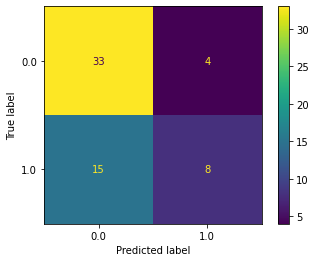

In [56]:
plot_confusion_matrix(rf, X_test, y_test)  

In [57]:
importances = list(rf.feature_importances_)

In [60]:
feature_list = list(features.columns)

feature_importances = [(feature, round(importance, 10)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances[:10]]

Variable: MEM_score            Importance: 0.0121630276
Variable: 126_245              Importance: 0.0014122692
Variable: 205_228              Importance: 0.0014102438
Variable: 38_187               Importance: 0.0013628009
Variable: 13_217               Importance: 0.0013439068
Variable: 162_217              Importance: 0.0012403802
Variable: 180_205              Importance: 0.0012113322
Variable: 166_214              Importance: 0.0010998146
Variable: 39_187               Importance: 0.0010488796
Variable: 108_228              Importance: 0.0010374024


[None, None, None, None, None, None, None, None, None, None]

### log reg

In [87]:
logreg = LogisticRegression(penalty = 'elasticnet', solver = 'saga')

In [106]:
params_grid = {
                 'l1_ratio': np.linspace(0,  1, 11)
             }

In [109]:
grid_clf =  GridSearchCV(estimator = logreg, param_grid = params_grid, n_jobs = -1, cv = 10, verbose=3)

In [110]:
grid_clf.fit(X_train, y_train)


Fitting 10 folds for each of 11 candidates, totalling 110 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed:  5.1min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


GridSearchCV(cv=10,
             estimator=LogisticRegression(penalty='elasticnet', solver='saga'),
             n_jobs=-1,
             param_grid={'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
             verbose=3)

In [111]:
grid_clf. best_estimator_

LogisticRegression(l1_ratio=0.0, penalty='elasticnet', solver='saga')

In [112]:
grid_clf. best_params_

{'l1_ratio': 0.0}

In [113]:
grid_clf.cv_results_

{'mean_fit_time': array([ 8.86796091, 19.98393753, 21.10460567, 22.20843256, 22.20243001,
        22.45439906, 23.08209324, 23.40317636, 23.53983307, 23.46901612,
        23.2556438 ]),
 'std_fit_time': array([0.11498919, 0.55547997, 0.91422525, 0.95621218, 0.97365965,
        0.59228699, 0.43070936, 0.27232379, 0.08993923, 0.13835739,
        0.35252846]),
 'mean_score_time': array([0.00030003, 0.00381575, 0.00280149, 0.00764868, 0.00050001,
        0.00364327, 0.00245912, 0.00020003, 0.00100126, 0.        ,
        0.0038254 ]),
 'std_score_time': array([0.00090008, 0.00163726, 0.00087186, 0.01239407, 0.00102462,
        0.00607818, 0.00477744, 0.0006001 , 0.00126665, 0.        ,
        0.00605808]),
 'param_l1_ratio': masked_array(data=[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,
                    0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 1.0],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False],
        f

In [ ]:
logreg = LogisticRegression(penalty = 'elasticnet', solver = 'saga', 'l1_ratio' = )
logreg.fit(X_train, y_train)
predictions = logreg.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test,predictions)
precision = precision_score(y_test,predictions)
recall = recall_score(y_test,predictions)
f1 = f1_score(y_test,predictions)
auc = roc_auc_score(y_test,predictions)

In [ ]:
pd.DataFrame({"Accuracy":[accuracy], "Precision":[precision], "Recall": [recall], "F1":[f1], "AUC":[auc]})

In [ ]:
plot_confusion_matrix(logreg, X_test, y_test)  